# Machine Learning for Texts

## Project description
The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. We'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. Can we reach an F1 score of at least 0.85?

### Import Libraries

In [1]:
# Making sure the reviewer has the same libraries version as I do.
#!pip install -U sklearn
#!pip install -U pandas
#!pip install -U matplotlib
#!pip install -U numpy
#!pip install -U catboost
#!pip install -U lightgbm
#!pip install -U xgboost
#!pip install -U spacy
#!python -m spacy download en
#!pip install -U wordcloud

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import GridSearchCV

from wordcloud import WordCloud
from tqdm.auto import tqdm

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

C:\Users\bonse\AppData\Local\Temp\ipykernel_29300\1225062909.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

### Import Data

In [6]:
try:
    df_reviews = pd.read_csv('./datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
def investigate_data(data):
    print(' ==================== Table ==========================')
    display(data.head())
    print(' -------------------- Info ---------------------------')
    print(data.info())
    print('The shape is:', data.shape)
    display(' -------------- Null Values ----------------------')
    total_cells=data.shape[0]*data.shape[1]
    null_values=total_cells-data.count().sum()
    print(f'There are {null_values:,} null values which is {null_values/total_cells:.2%} of the total data.')
    null_rows=(data.isnull().sum(axis=1)>0).sum()
    print(f'There are {null_rows:,} rows with null values which is {null_rows/data.shape[0]:.2%} of the total rows.')
    print(' -------------- Data description ----------------------')
    display(data.describe().T)
    print('Number of duplicated rows :', data.duplicated().sum())

In [8]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [9]:
investigate_data(df_reviews)

 ==================== Table ==========================


,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


 -------------------- Info ---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx

' -------------- Null Values ----------------------'

There are 4 null values which is 0.00% of the total data.
There are 2 rows with null values which is 0.00% of the total rows.
 -------------- Data description ----------------------


,count,mean,std,min,25%,50%,75%,max
start_year,47331.0,1989.631235,19.600364,1894.0,1982.0,1998.0,2004.0,2010.0
is_adult,47331.0,0.001732,0.041587,0.0,0.0,0.0,0.0,1.0
average_rating,47329.0,5.998278,1.494289,1.4,5.1,6.3,7.1,9.7
votes,47329.0,25562.917323,83670.039163,9.0,827.0,3197.0,13974.0,1739448.0
rating,47331.0,5.484608,3.473109,1.0,2.0,4.0,9.0,10.0
pos,47331.0,0.498954,0.500004,0.0,0.0,0.0,1.0,1.0
idx,47331.0,6279.697999,3605.702545,0.0,3162.0,6299.0,9412.0,12499.0


Number of duplicated rows : 0


We do not identify any problems with our data at this point.

## EDA

Let's check the number of movies and reviews over years.

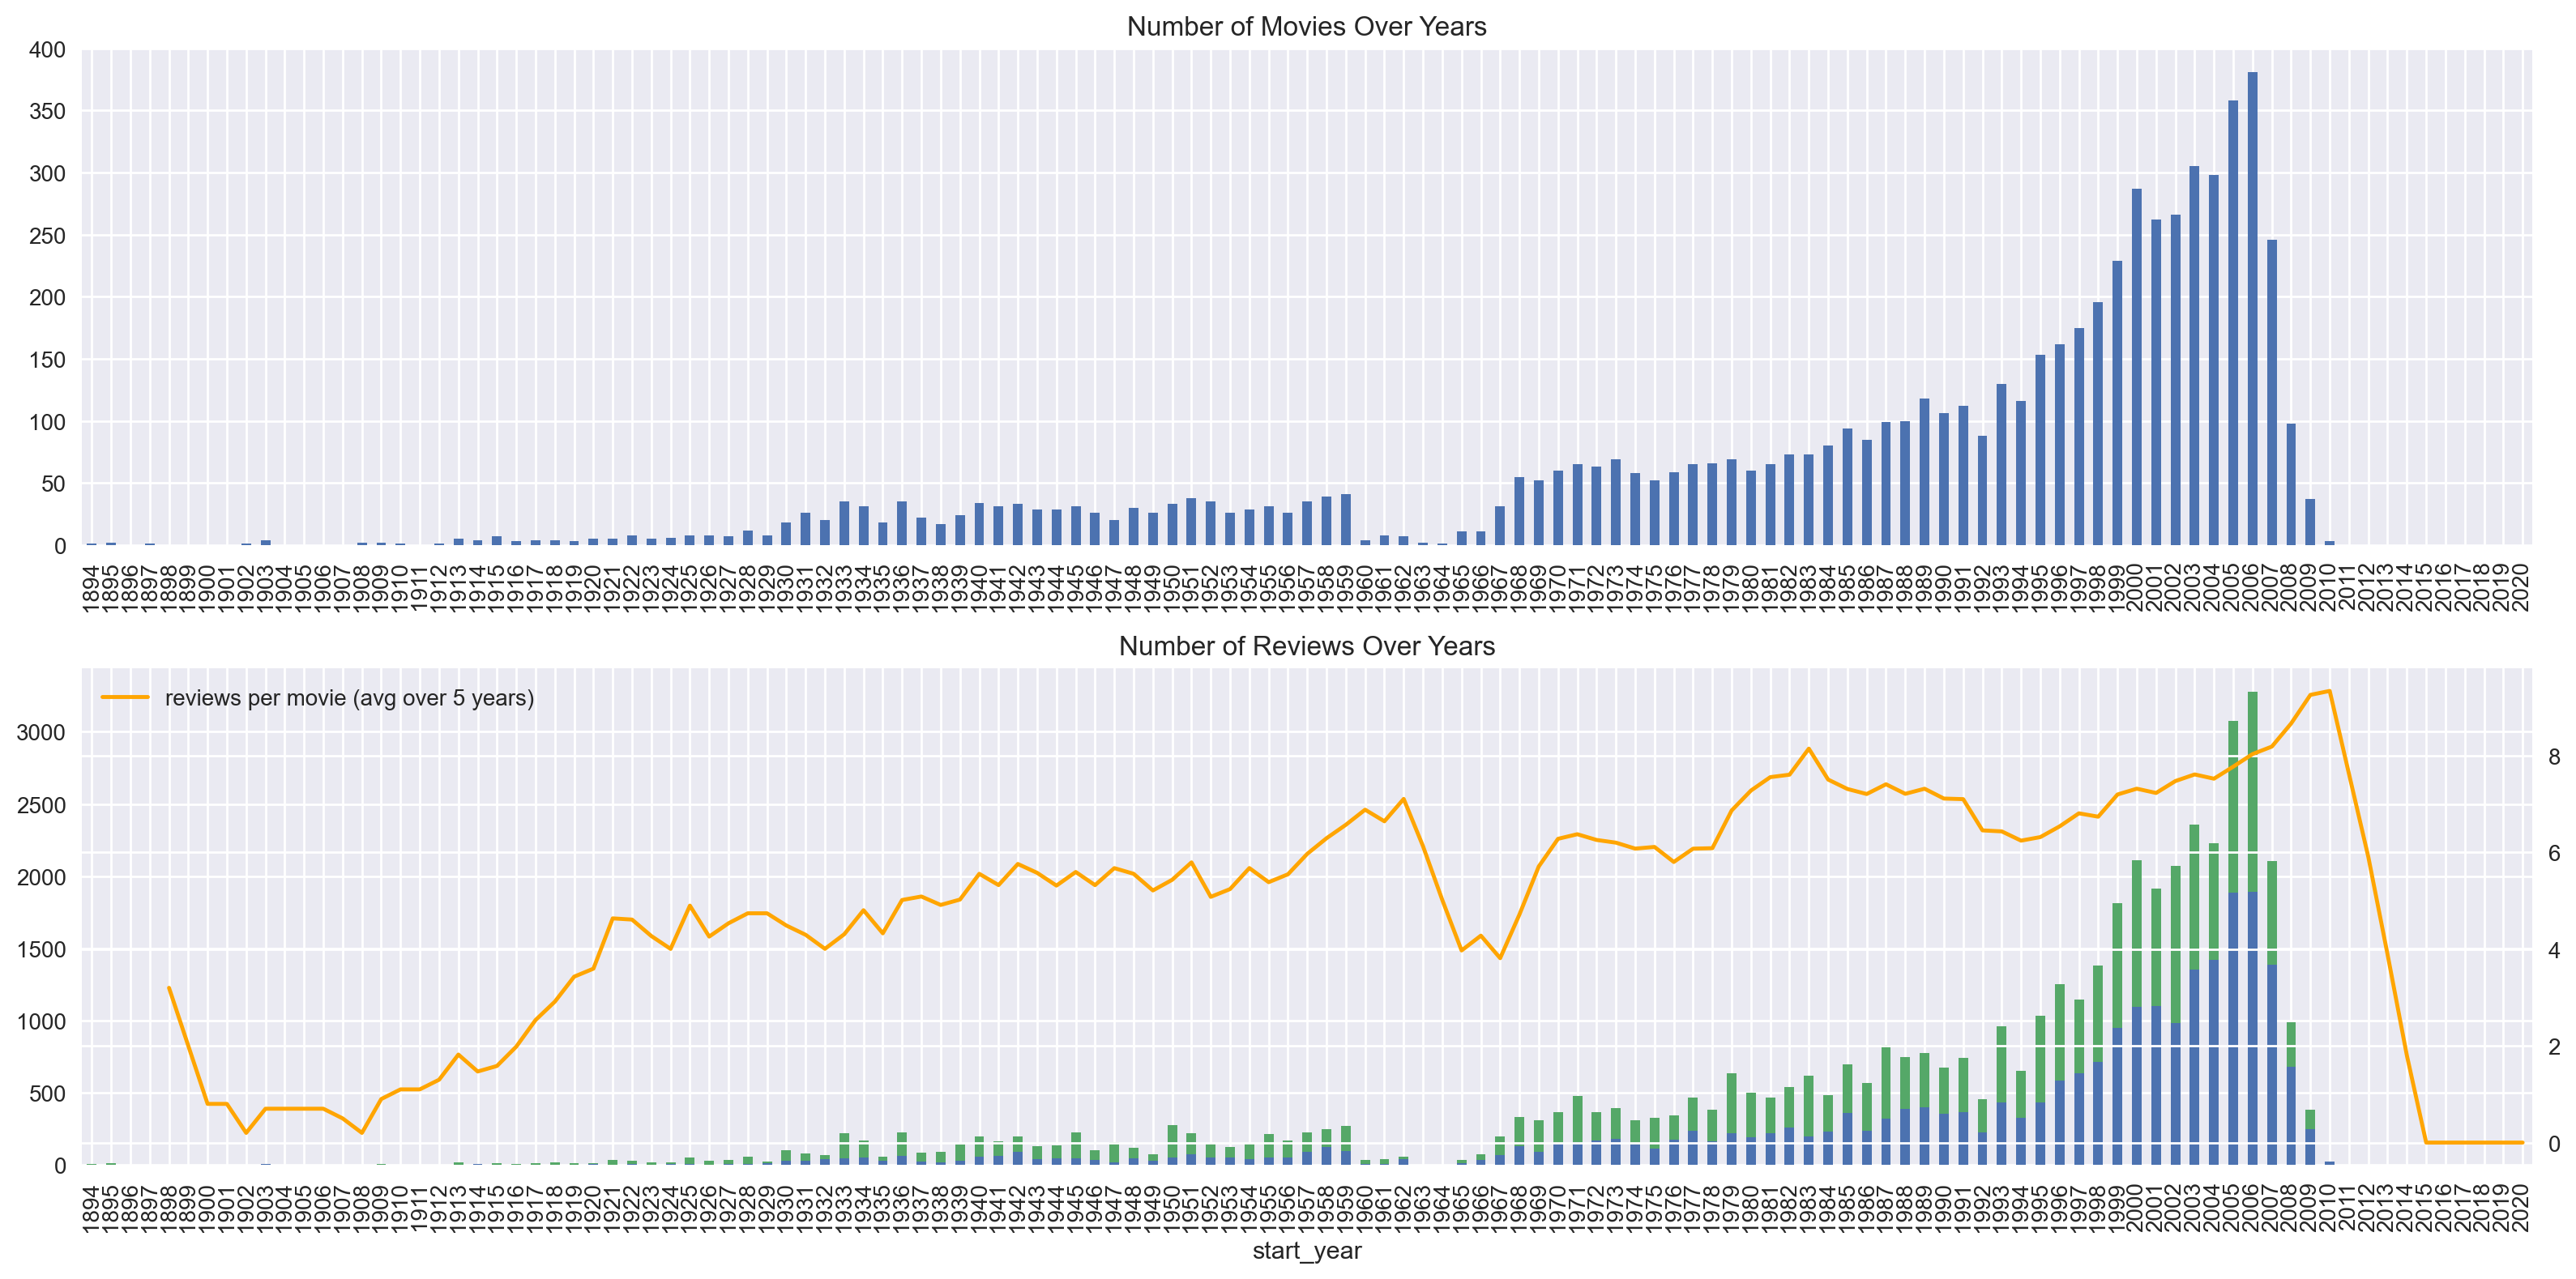

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

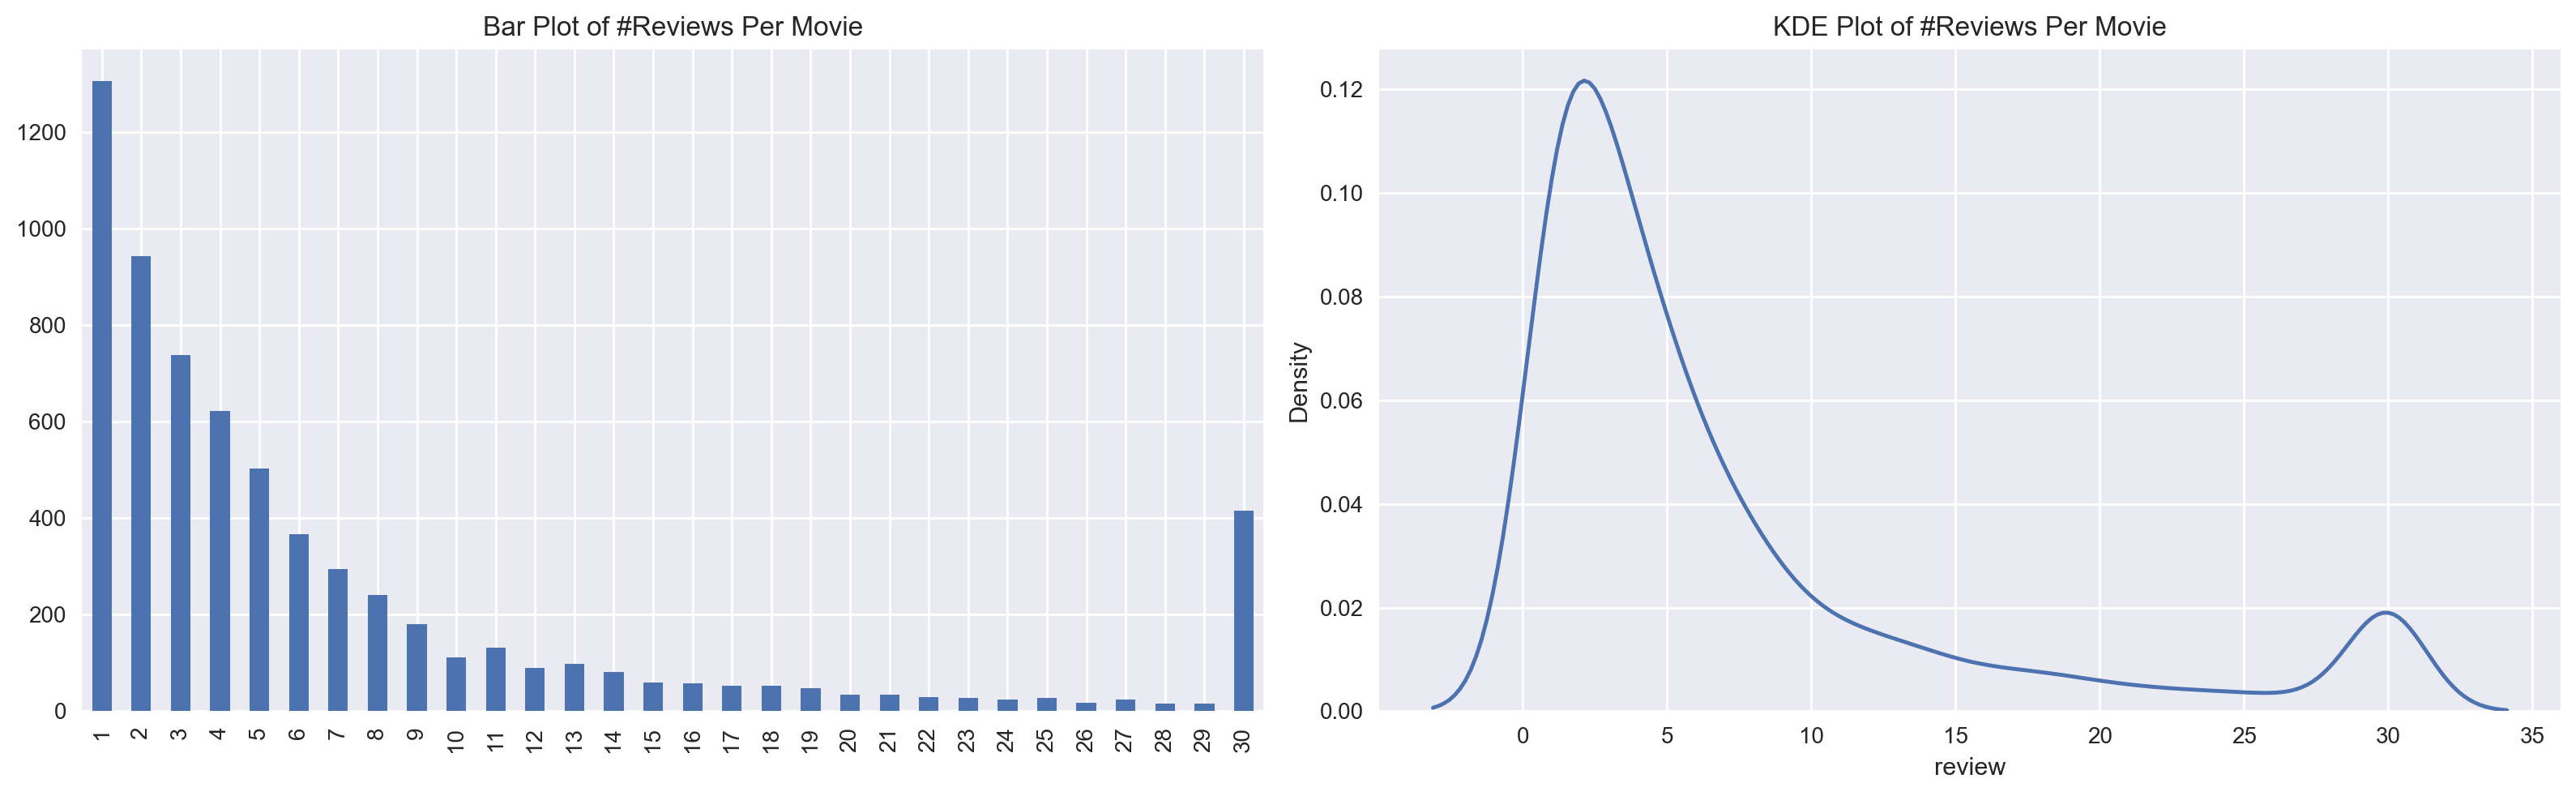

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

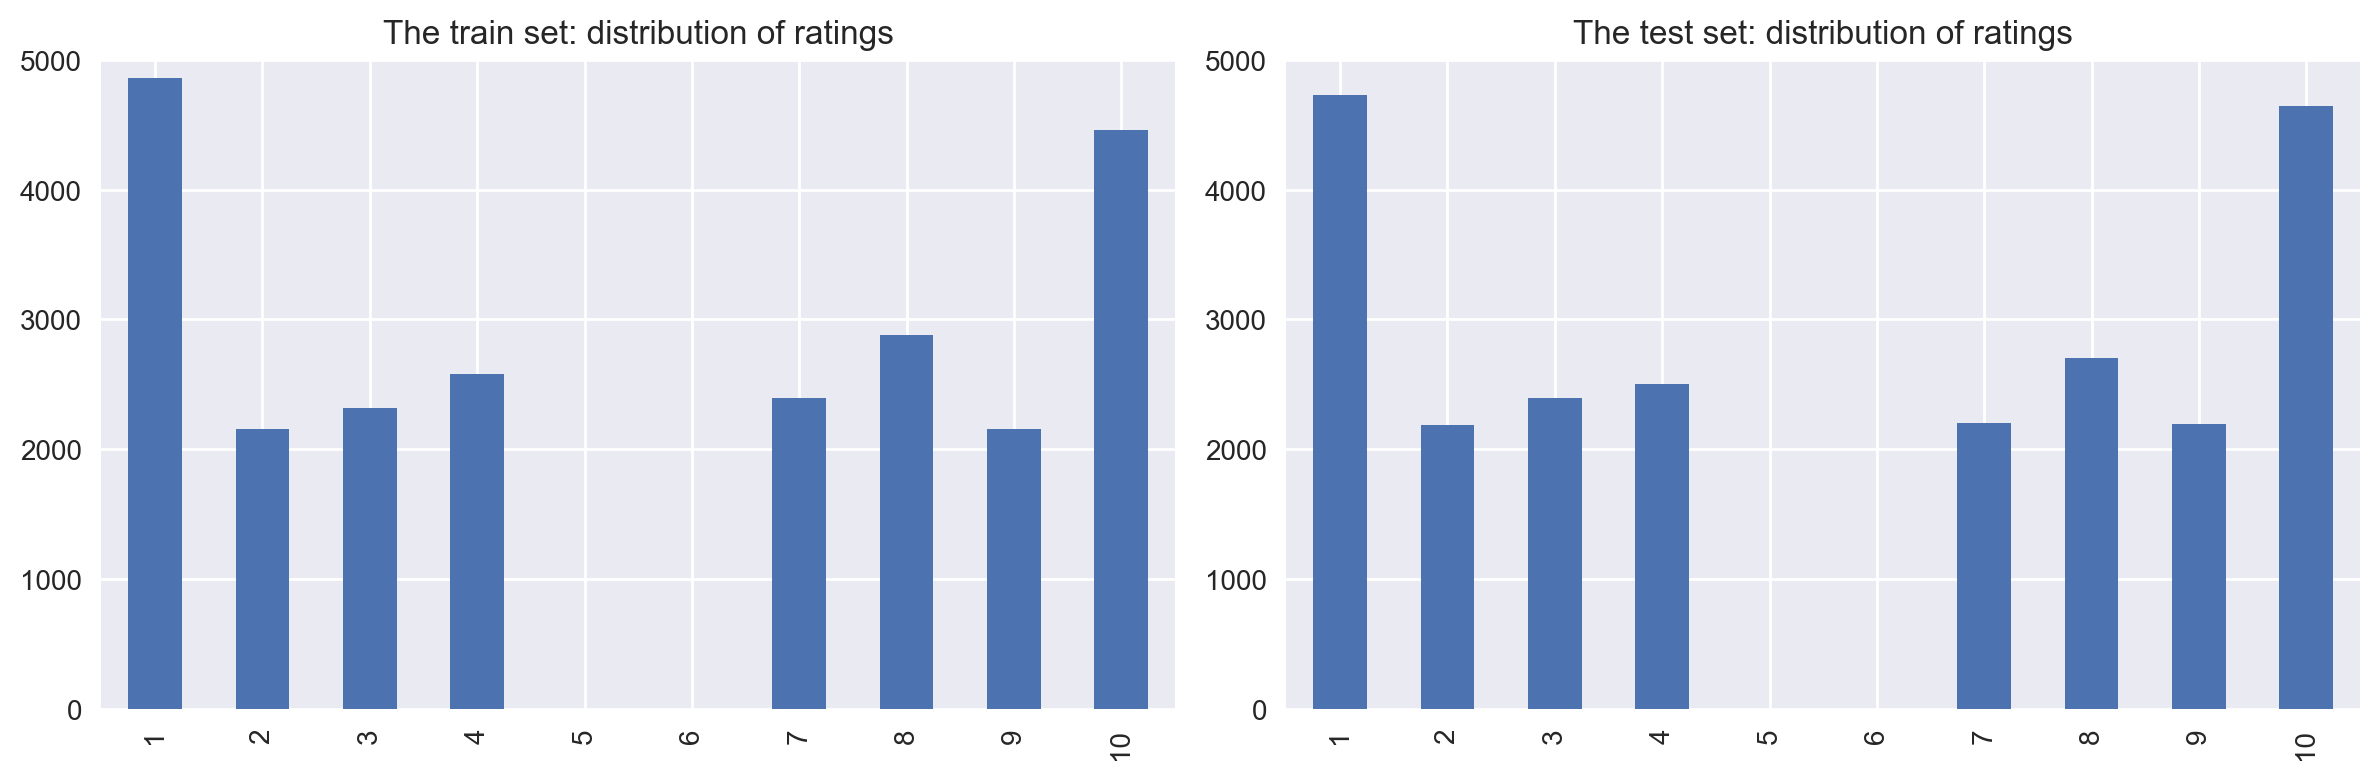

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

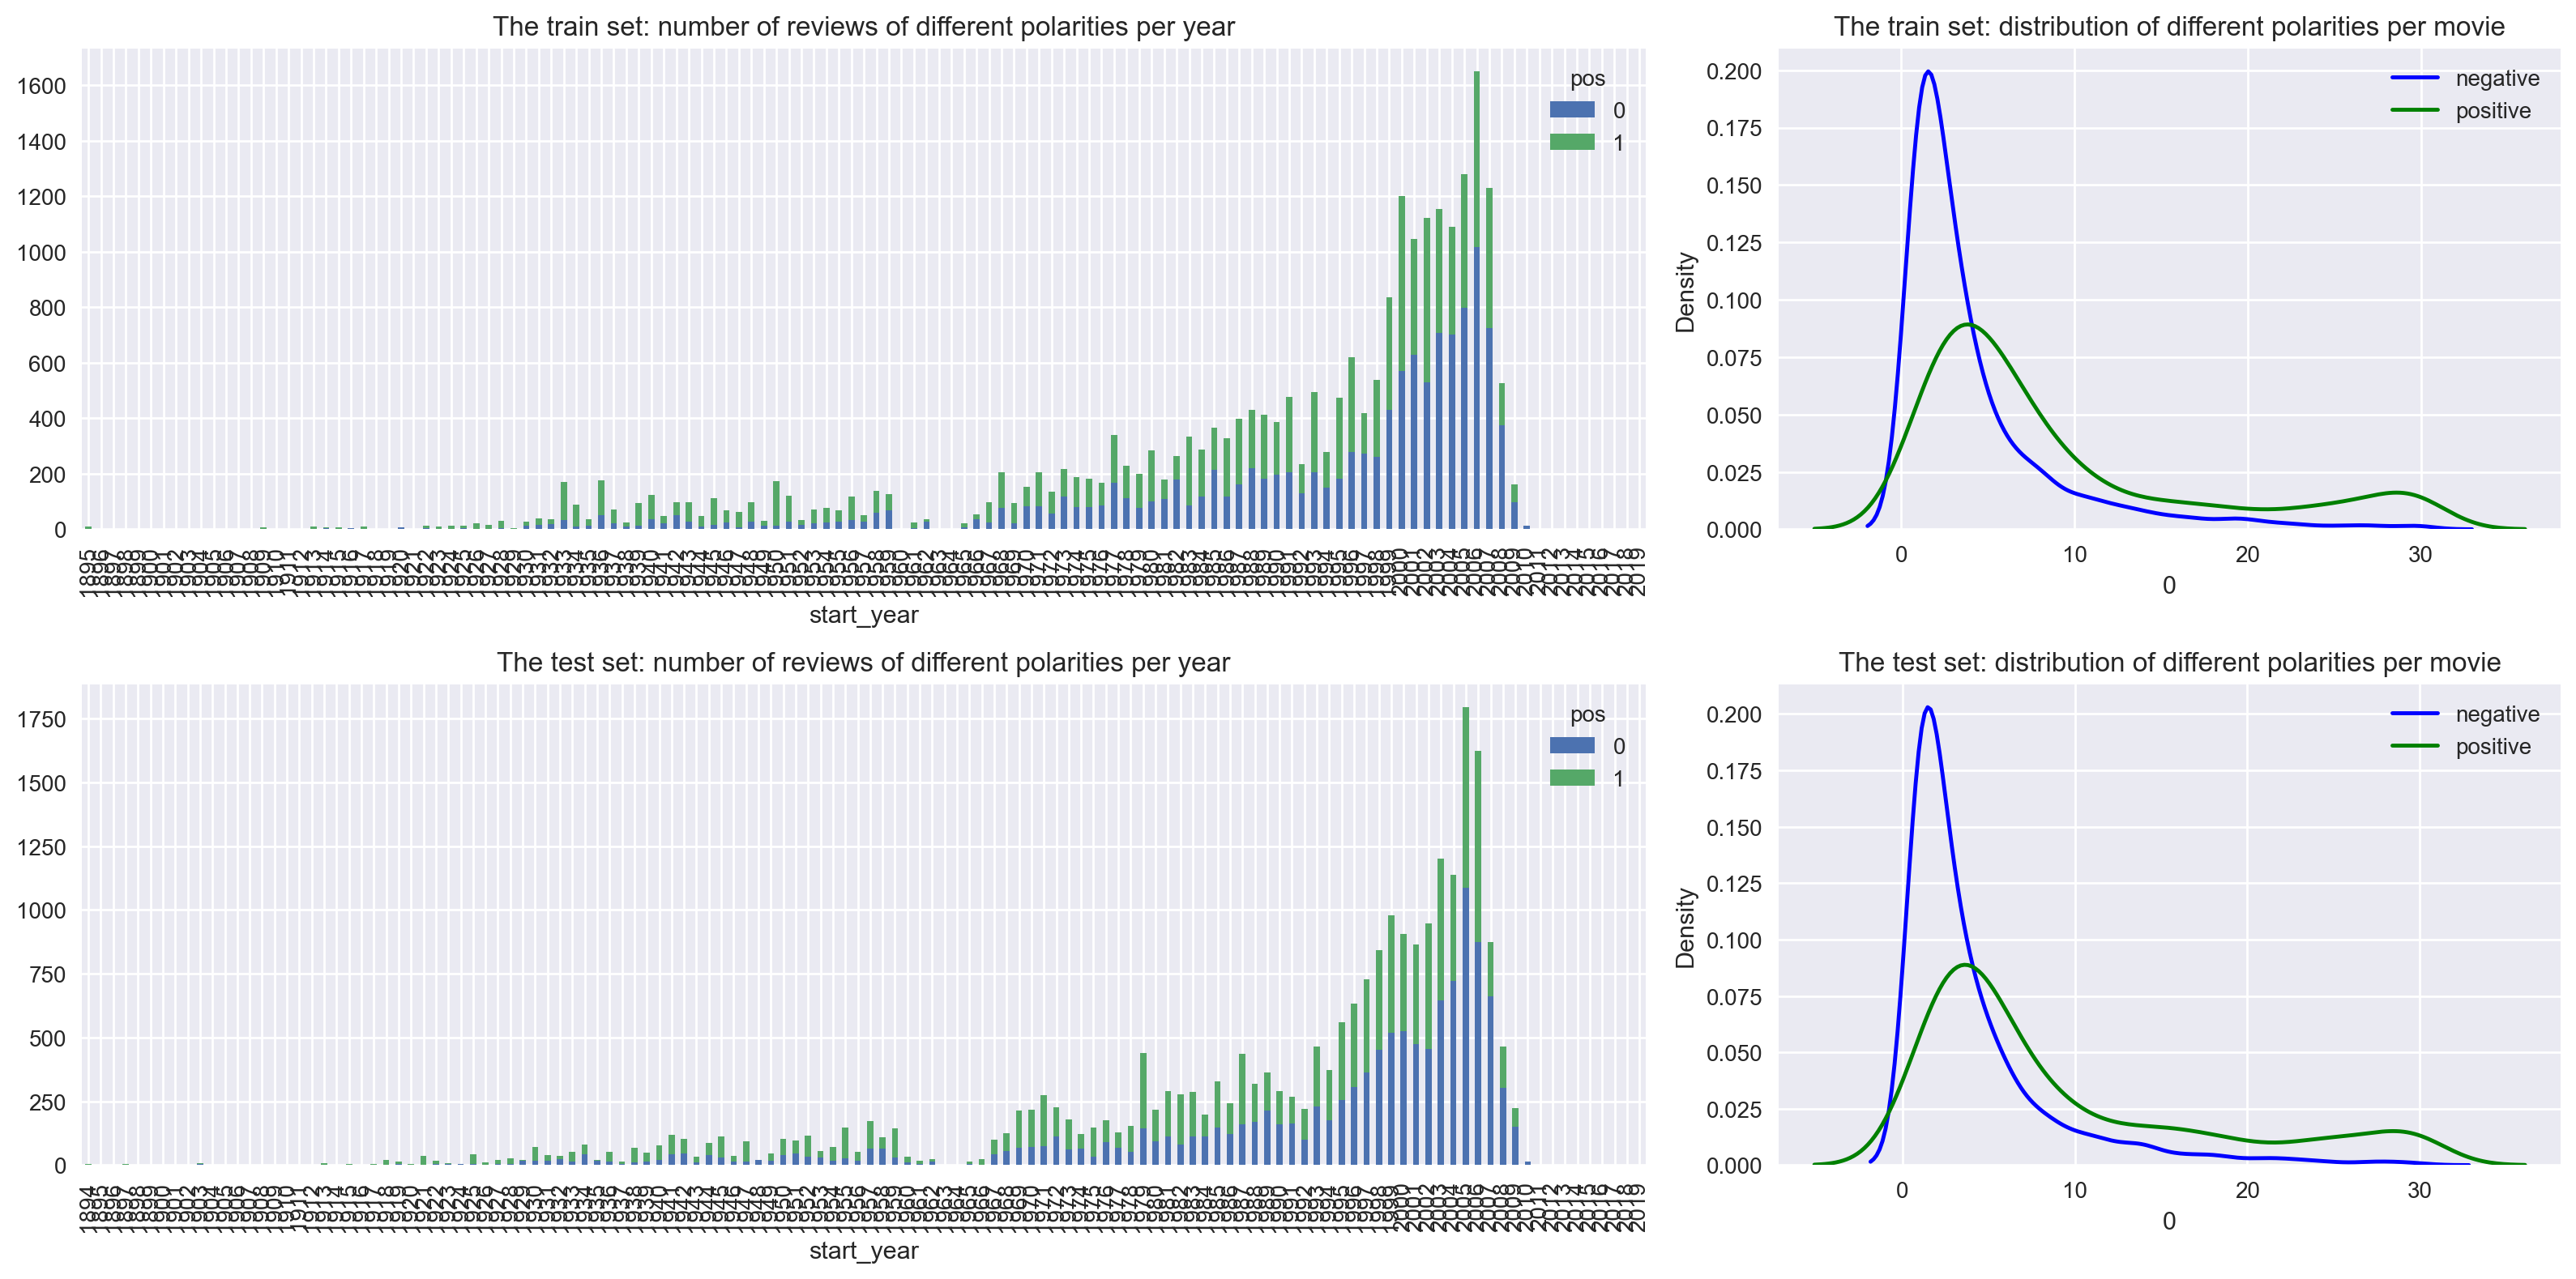

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The difference between positive and negative reviews over the years

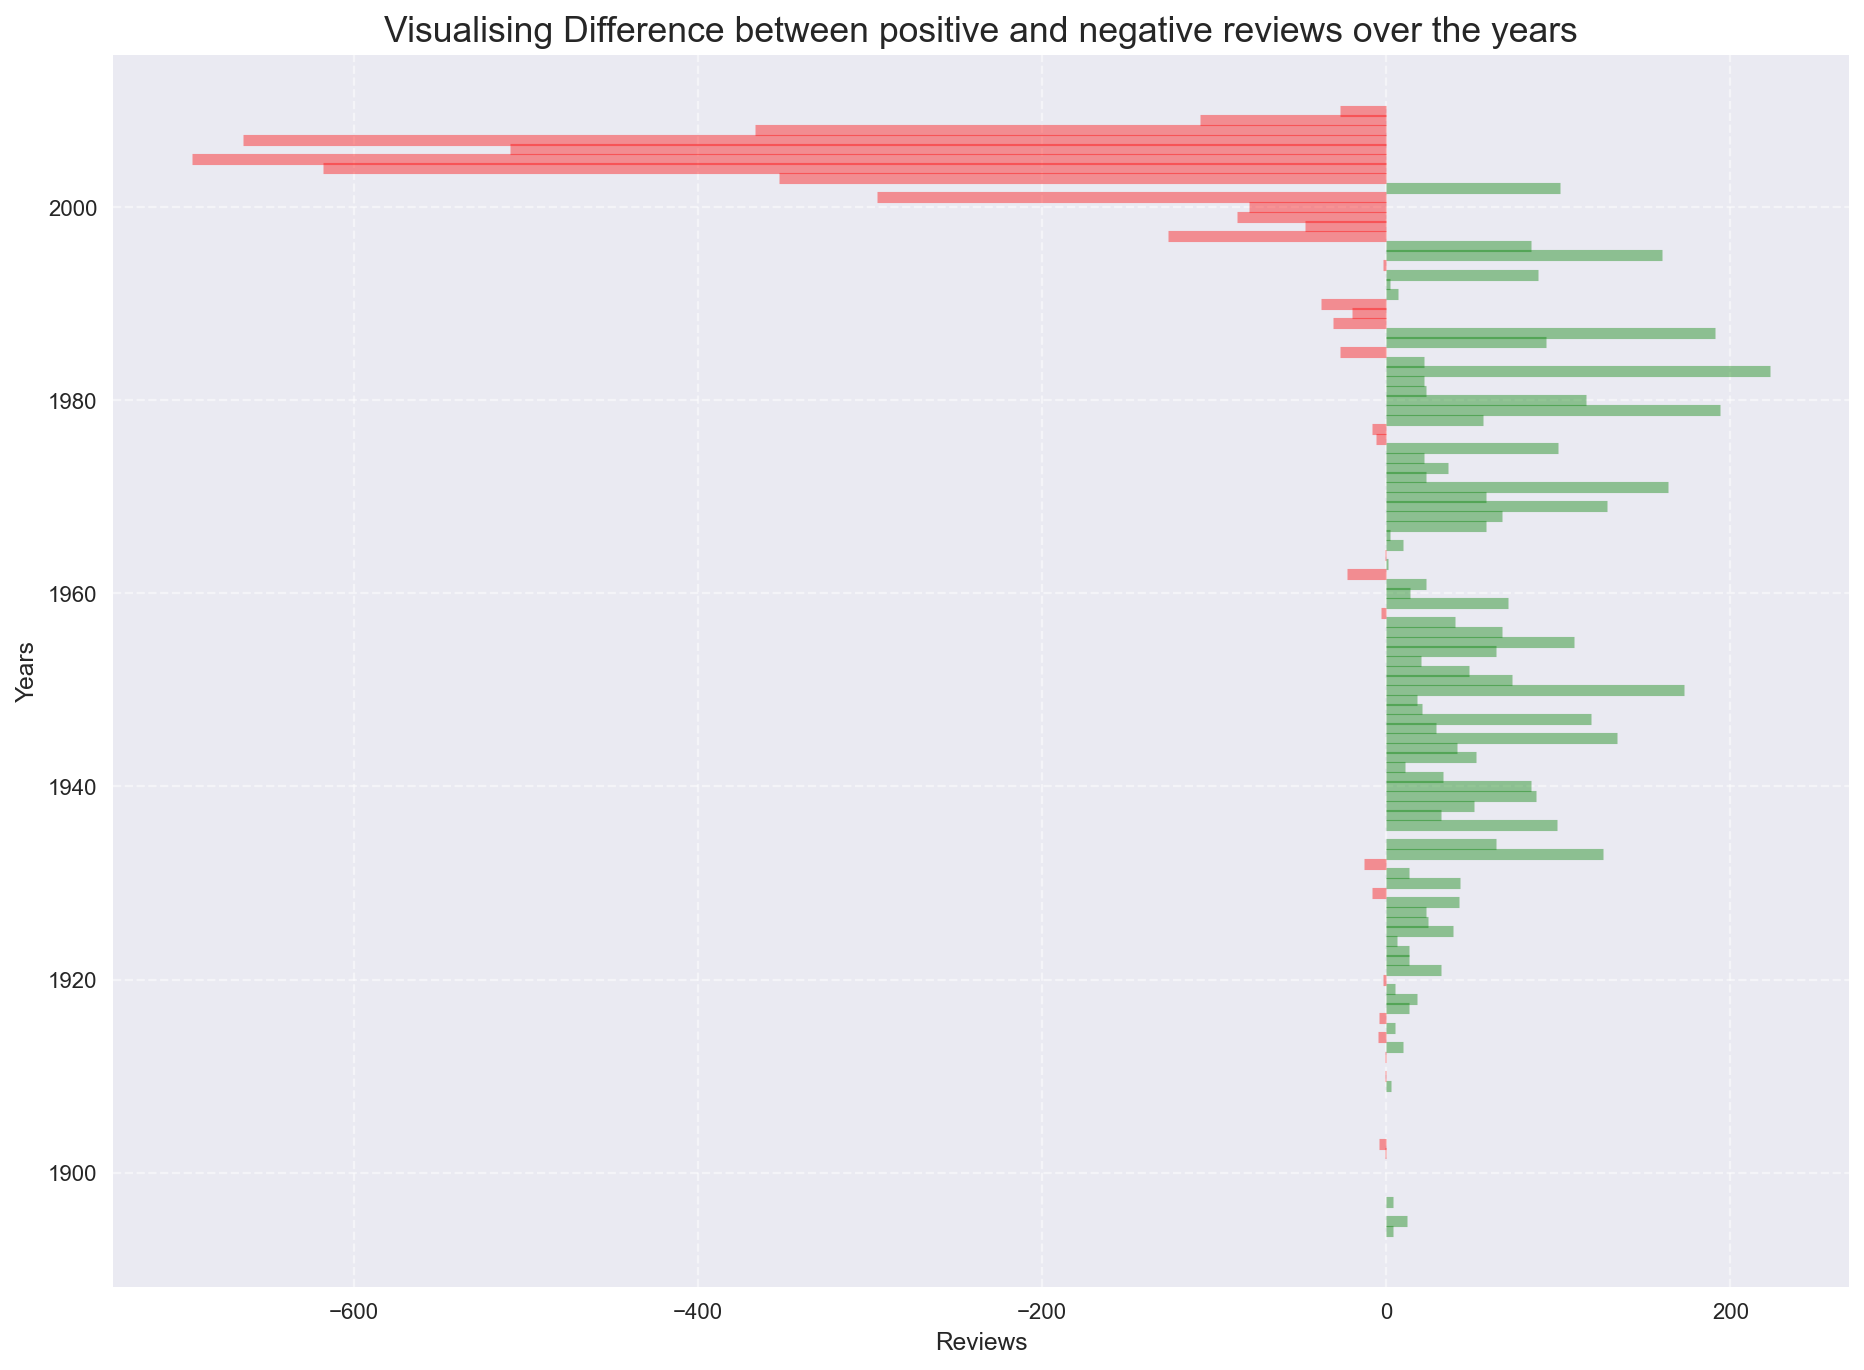

In [15]:
# Preparing the data to be plotted
dft = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack().fillna(0)
dft['difference']=dft[1]-dft[0]
dft['colors'] = ['red' if float(x) < 0 else 'green' for x in dft['difference']]

plt.figure(figsize=(14, 10), dpi=80)
# Plotting the horizontal lines
plt.hlines(y=dft.index, xmin=0, xmax=dft.difference,color=dft.colors, alpha=0.4, linewidth=5)
# Decorations
plt.gca().set(ylabel='Years', xlabel='Reviews')
plt.title('Visualising Difference between positive and negative reviews over the years', fontdict={'size': 16})
plt.grid(linestyle='--', alpha=0.5)
plt.show()


This is interesting. It seems that lately people are increasingly disappointed in movies. Or that we only have reviews on the good movies from before the IMDB era and the bad movies are forgotten, while now we have reviews on every movie made.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [16]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [17]:
import re

def normalize_text(text):
    _text=text.lower()
    _text=re.sub(r'[^a-zA-Z\']', ' ', _text)
    return " ".join(_text.split())

In [18]:
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [19]:
df_reviews.T

,0,1,2,3,4,5,6,7,8,9,...,47321,47322,47323,47324,47325,47326,47327,47328,47329,47330
tconst,tt0068152,tt0068152,tt0313150,tt0313150,tt0313150,tt0313150,tt0313150,tt0035958,tt0035958,tt0035958,...,tt0068398,tt0068398,tt0068398,tt0068398,tt0068398,tt0068398,tt0223503,tt0223503,tt0223503,tt0223503
title_type,movie,movie,short,short,short,short,short,movie,movie,movie,...,tvEpisode,tvEpisode,tvEpisode,tvEpisode,tvEpisode,tvEpisode,tvMovie,tvMovie,tvMovie,tvMovie
primary_title,$,$,'15','15','15','15','15','Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,...,Étude in Black,Étude in Black,Étude in Black,Étude in Black,Étude in Black,Étude in Black,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru
original_title,$,$,'15','15','15','15','15','Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,...,Étude in Black,Étude in Black,Étude in Black,Étude in Black,Étude in Black,Étude in Black,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru
start_year,1971,1971,2002,2002,2002,2002,2002,1943,1943,1943,...,1972,1972,1972,1972,1972,1972,1996,1996,1996,1996
end_year,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
runtime_minutes,121,121,25,25,25,25,25,88,88,88,...,97,97,97,97,97,97,55,55,55,55
is_adult,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
genres,"Comedy,Crime,Drama","Comedy,Crime,Drama","Comedy,Drama,Short","Comedy,Drama,Short","Comedy,Drama,Short","Comedy,Drama,Short","Comedy,Drama,Short","Drama,History,War","Drama,History,War","Drama,History,War",...,"Crime,Drama,Mystery","Crime,Drama,Mystery","Crime,Drama,Mystery","Crime,Drama,Mystery","Crime,Drama,Mystery","Crime,Drama,Mystery","Animation,Biography,Drama","Animation,Biography,Drama","Animation,Biography,Drama","Animation,Biography,Drama"
average_rating,6.3,6.3,6.3,6.3,6.3,6.3,6.3,6.1,6.1,6.1,...,7.7,7.7,7.7,7.7,7.7,7.7,7.3,7.3,7.3,7.3


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Checking word composition of the Train/Test sets
We check the most frequently used words in the train and test set (apart from stop words).

In [21]:
#Create the spacy object.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
#Obtain set of stopwords from spacy.
spc_stop_words = nlp.Defaults.stop_words

In [22]:
from collections import Counter
def top_most_common_words(texts,length=40):
    temp_list = texts.apply(lambda x:str(x).split())
    top = pd.DataFrame(Counter([item for sublist in temp_list for item in sublist if not item in spc_stop_words]).most_common(length))
    return top[0],top[1]

temp =pd.DataFrame()
temp['__train_words__   '],temp['__train_count__   ']=top_most_common_words(df_reviews_train['review_norm'])
temp['__test_words__   '],temp['__test_count__   ']=top_most_common_words(df_reviews_test['review_norm'])
properties = {"border": "1px solid black", "width": "65px", "text-align": "center"}
temp.style.background_gradient(cmap='Blues').set_properties(**properties)

,__train_words__,__train_count__,__test_words__,__test_count__
0,movie,41785,movie,41190
1,film,37702,film,36265
2,like,19321,like,18801
3,it's,16351,it's,15379
4,good,14379,good,13779
5,time,12076,time,11658
6,story,11314,story,10480
7,bad,8881,bad,8638
8,people,8713,great,8572
9,great,8611,people,8170


We see that the sets have very similar composition, with the order of word frequency almost identical.

## Working with models

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
dummy_clf = DummyClassifier(strategy='constant',random_state=None,constant=1)

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


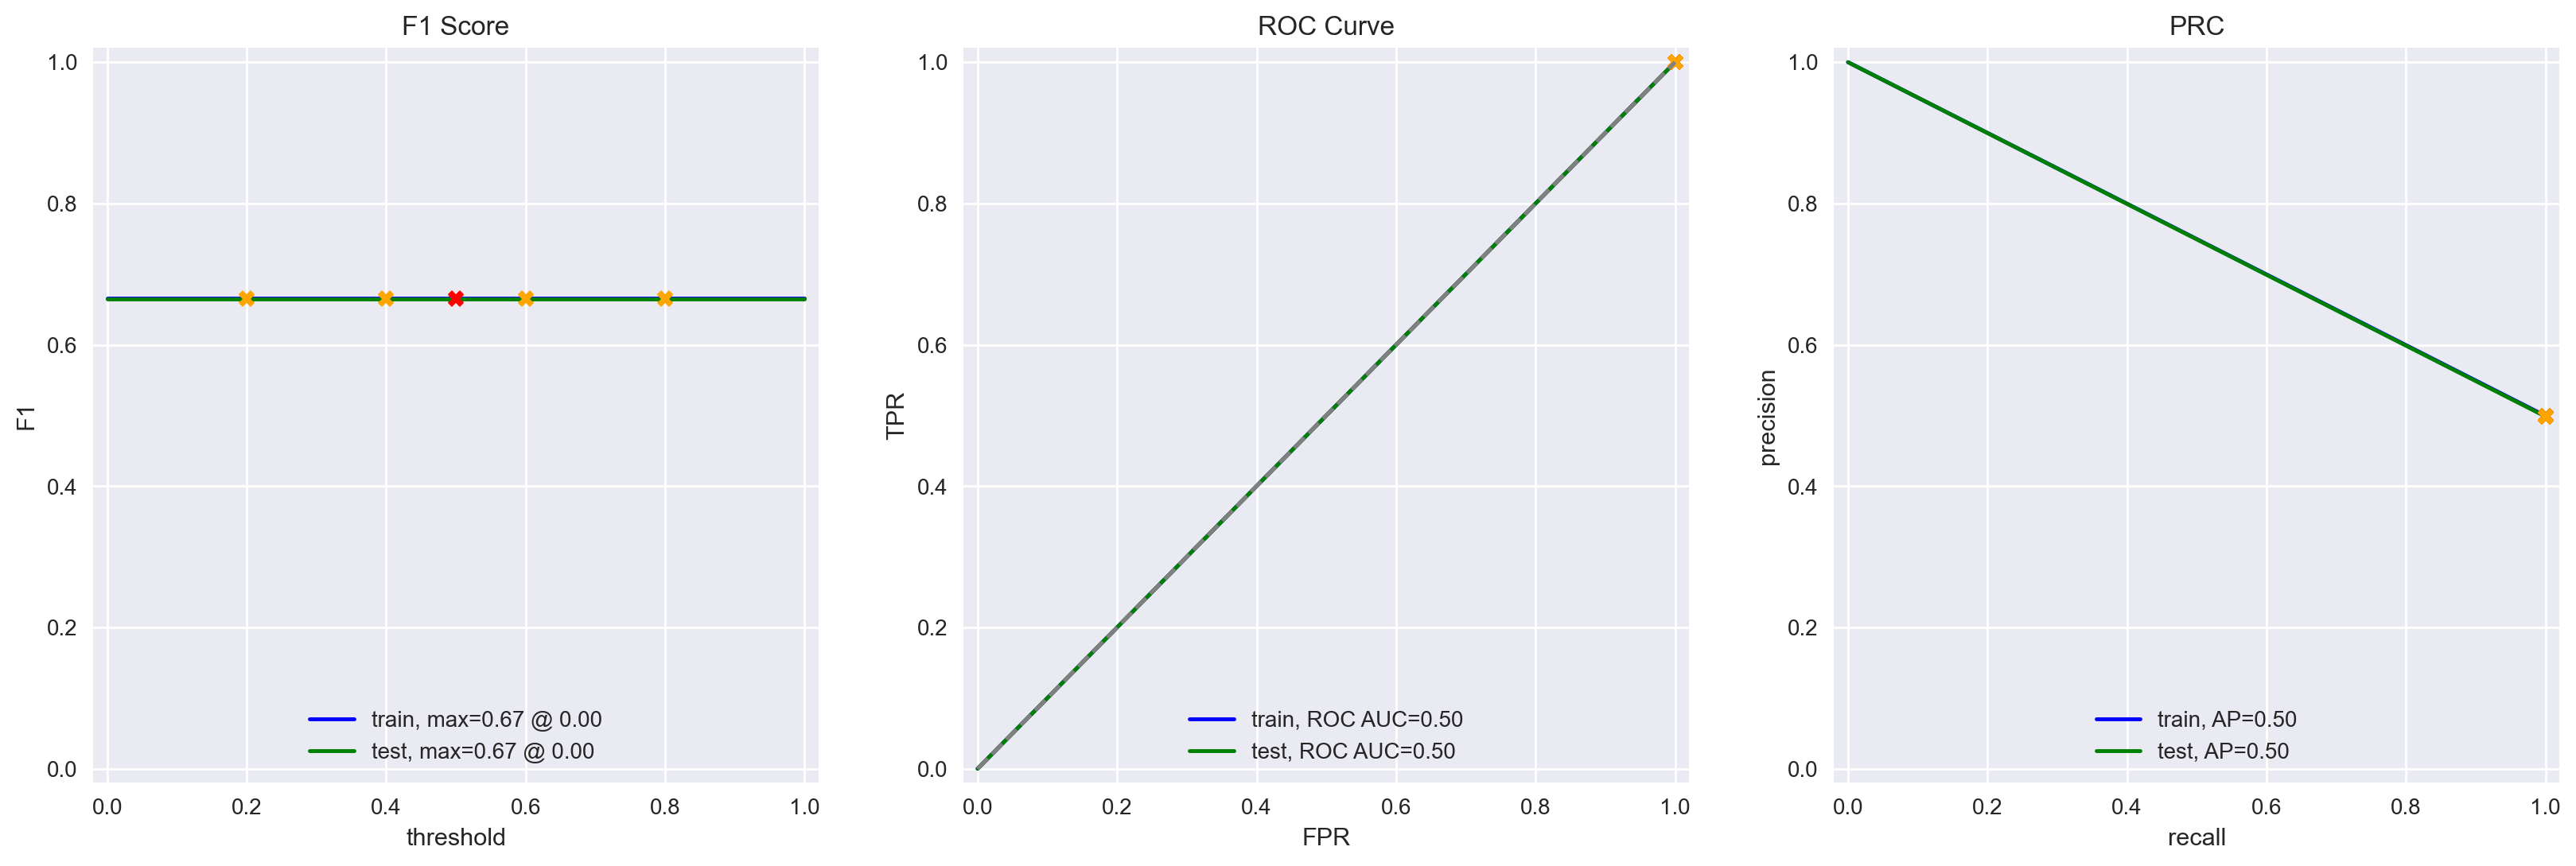

In [25]:
dummy_clf.fit(df_reviews_train,train_target)
dumy_pred=dummy_clf.predict(df_reviews_test)
evaluate_model(dummy_clf,df_reviews_train,train_target,df_reviews_test,test_target)

In [26]:
#We'll hold here the results
f1_scores=pd.DataFrame(columns=['Model Name','Max F1 Train Score','Max F1 Test Score'])
f1_scores.loc[len(f1_scores)]=['Dummy Constant Classifier',0.67,0.67]

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [27]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [28]:
nltk_stop_words = set(stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words= nltk_stop_words)

In [29]:
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

In [30]:
model_1= LogisticRegression()
model_1.fit(train_features_1,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


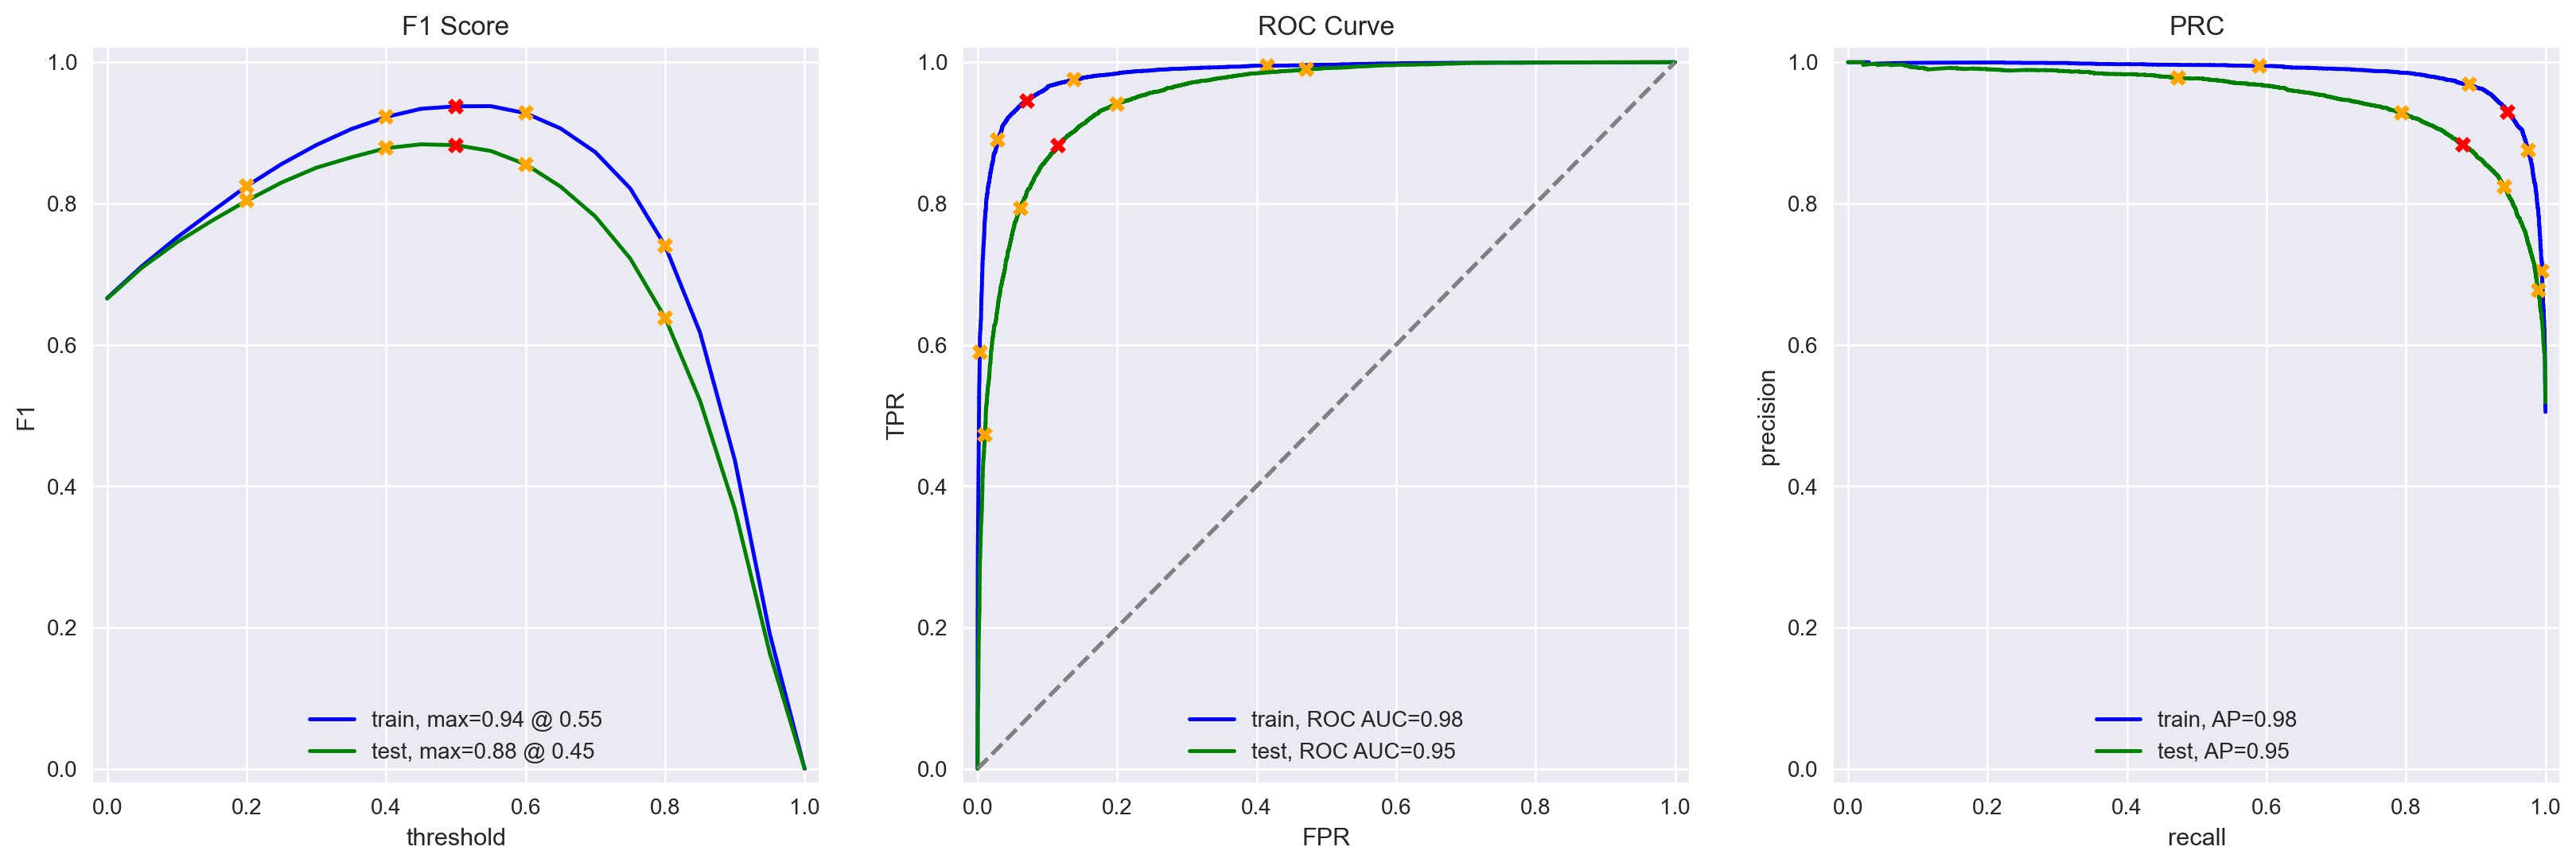

In [31]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

In [32]:
f1_scores.loc[len(f1_scores)]=['NLTK, TF-IDF and Logistic Regression',0.94,0.88]

### Model 3 - spaCy, TF-IDF and LR

In [33]:
def text_preprocessing_3(text):

    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [34]:
train_spc_text=df_reviews_train['review_norm'].copy()
test_spc_text=df_reviews_test['review_norm'].copy()
train_spc_text.progress_apply(text_preprocessing_3)
test_spc_text.progress_apply(text_preprocessing_3)

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

2        real story film like fly wall drama documentar...
3        um film troubled teen singapore country knowle...
4        totally agree garryjohal singapore comment fil...
5        movie see singapore great know lot asia langua...
6        yes non singaporean big deal film reference fi...
                               ...                        
47326    favorite columbo sport notch cast include john...
47327    talk bore get expect fascinating insight life ...
47328    think biopic near abundance characterization e...
47329    spirit chaos artistic biopic miyazawa kenji ja...
47330    brief joy watch effective character resemble r...
Name: review_norm, Length: 23535, dtype: object

In [35]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=spc_stop_words)

In [36]:
train_features_3 = tfidf_vectorizer_3.fit_transform(train_spc_text)
test_features_3 = tfidf_vectorizer_3.transform(test_spc_text)

In [37]:
model_3= LogisticRegression()
model_3.fit(train_features_3,train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


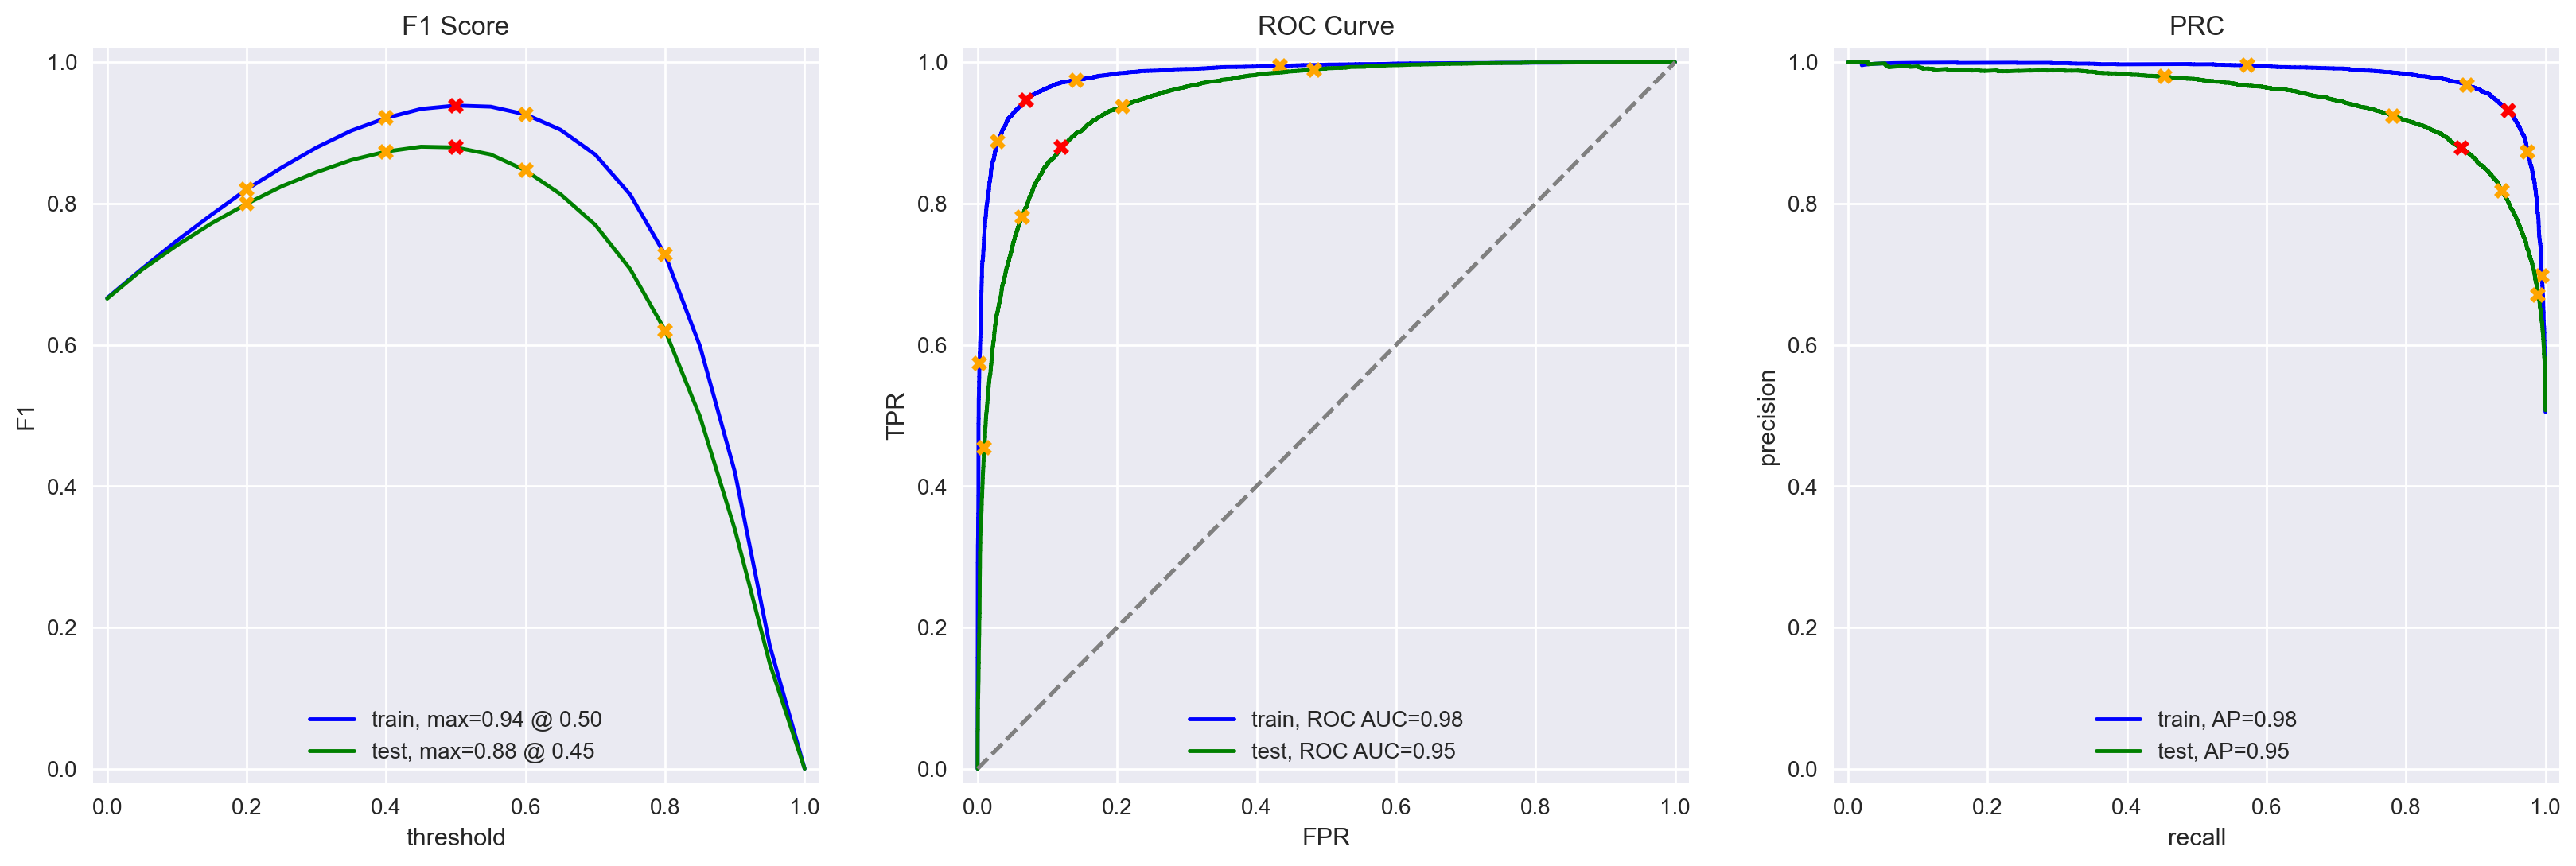

In [38]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

In [39]:
f1_scores.loc[len(f1_scores)]=['spaCy, TF-IDF and Logistic Regression',0.94,0.88]


### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [40]:
from lightgbm import LGBMClassifier

In [41]:
lgbm_estimator = LGBMClassifier(random_state=54321)
lgbm_grid = {    'num_leaves': [7, 21, 50],
                 'learning_rate': [0.1, 0.03],
                 'max_depth': [ 3, 5],
                 'n_estimators': [50, 200]}
gs_lgbm = GridSearchCV(lgbm_estimator, param_grid=lgbm_grid, scoring='neg_mean_squared_error', cv = 3,return_train_score=True,
                       verbose=10, n_jobs=-1)
gs_lgbm.fit(train_features_3, train_target)
model_4=gs_lgbm.best_estimator_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


          train  test
Accuracy   0.89  0.84
F1         0.90  0.85
APS        0.96  0.92
ROC AUC    0.96  0.92


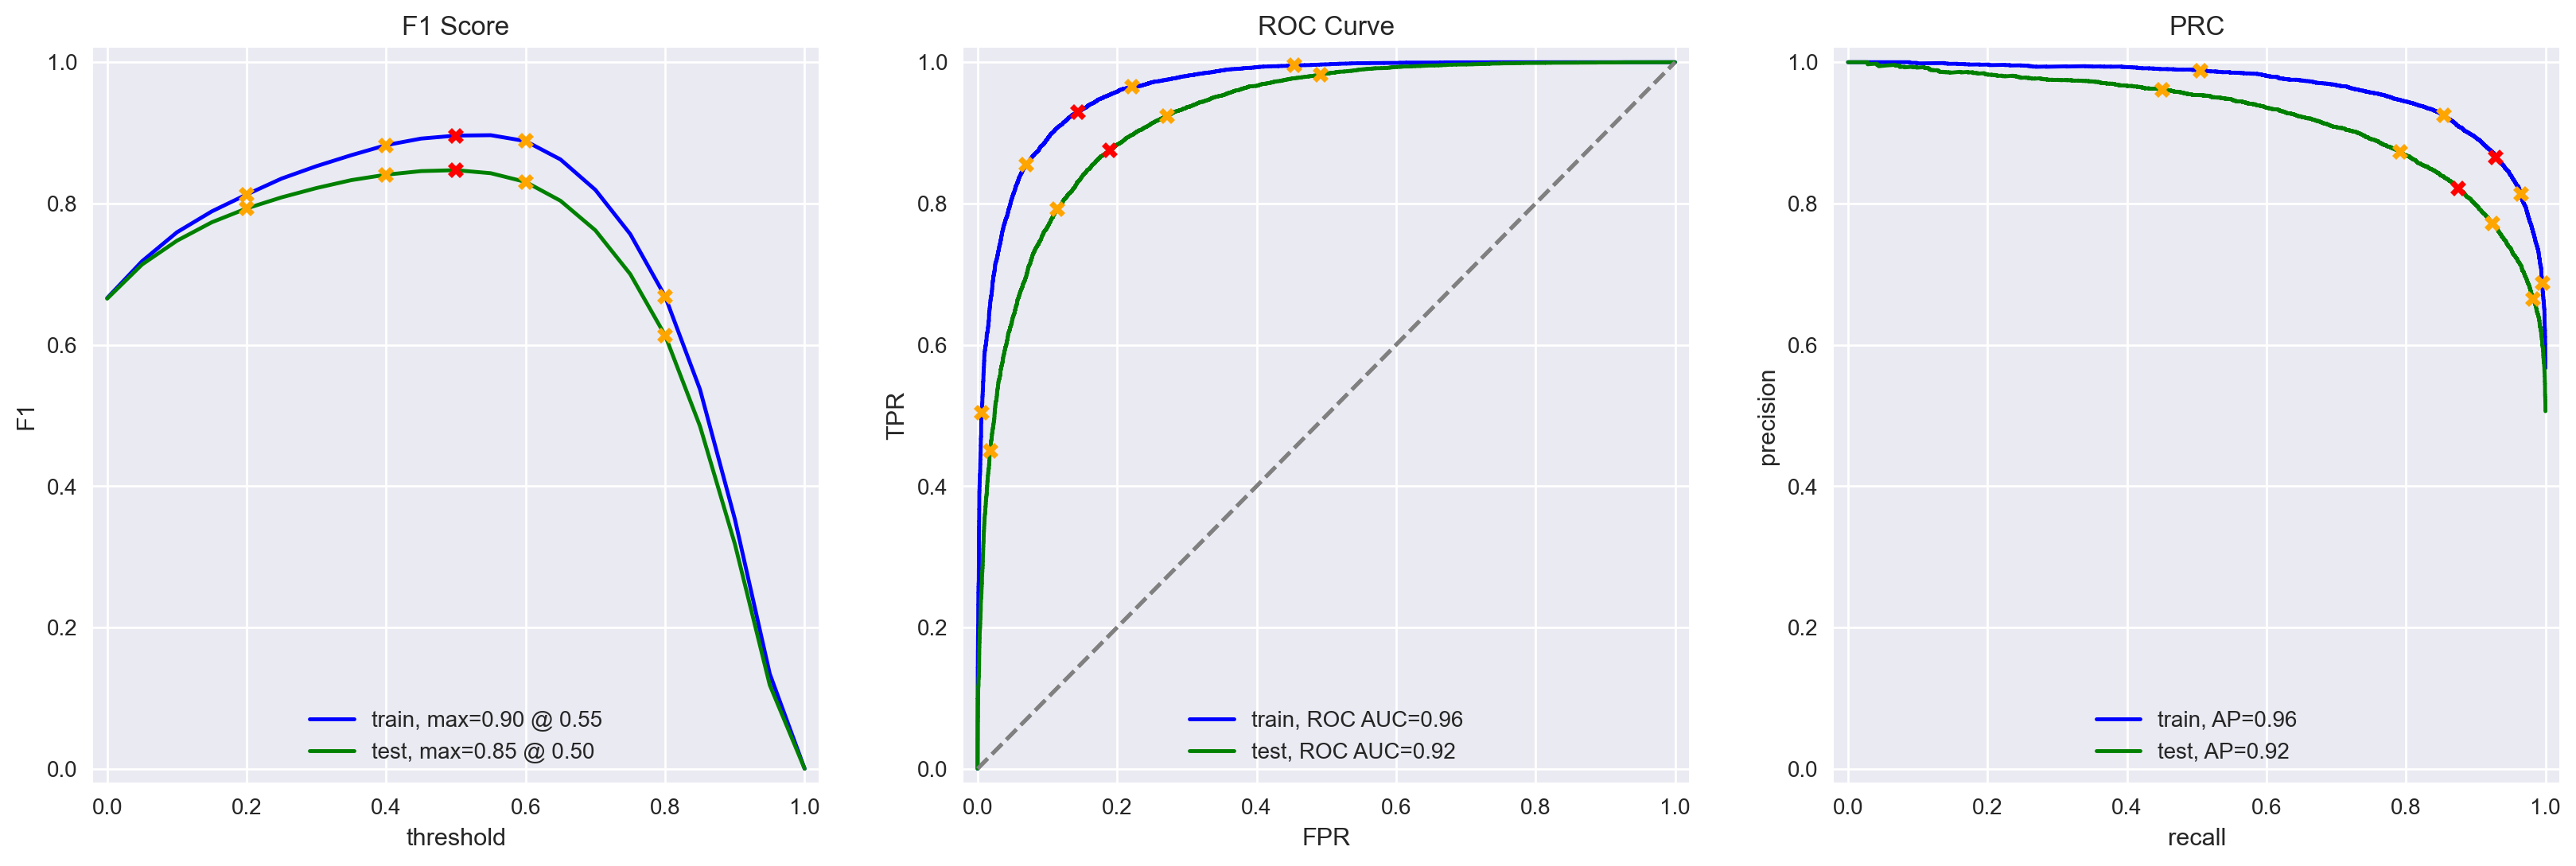

In [42]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

In [43]:
f1_scores.loc[len(f1_scores)]=['spaCy, TF-IDF and LGBMClassifier',0.90,0.85]

###  Model 9 - BERT

In [44]:
import torch
import transformers

torch.cuda.is_available()

False

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False,max_sample_size = 5000):

    ids_list = []
    attention_mask_list = []


    for input_text in texts.iloc[:max_sample_size]:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')

    # gettings embeddings in batches

    embeddings = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using the {device} device.')
    model.to(device)

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [47]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'],max_sample_size=5000)

Using the cpu device.
Using the cpu device.


  0%|          | 0/50 [00:00<?, ?it/s]

In [48]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'],max_sample_size=5000)

Using the cpu device.
Using the cpu device.


  0%|          | 0/50 [00:00<?, ?it/s]

In [49]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(5000, 768)
(23796,)


In [50]:
# if you have got the embeddings, it's advisable to save them to have them ready if
np.savez_compressed('features_9_2x5000.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [51]:

# and load...
with np.load('features_9_2x5000.npz') as data:
     train_features_9 = data['train_features_9']
     test_features_9 = data['test_features_9']

In [52]:
model_9 = LogisticRegression()
model_9.fit(train_features_9, train_target.iloc[:5000])

LogisticRegression()

          train  test
Accuracy   0.92  0.84
F1         0.91  0.83
APS        0.97  0.92
ROC AUC    0.97  0.93


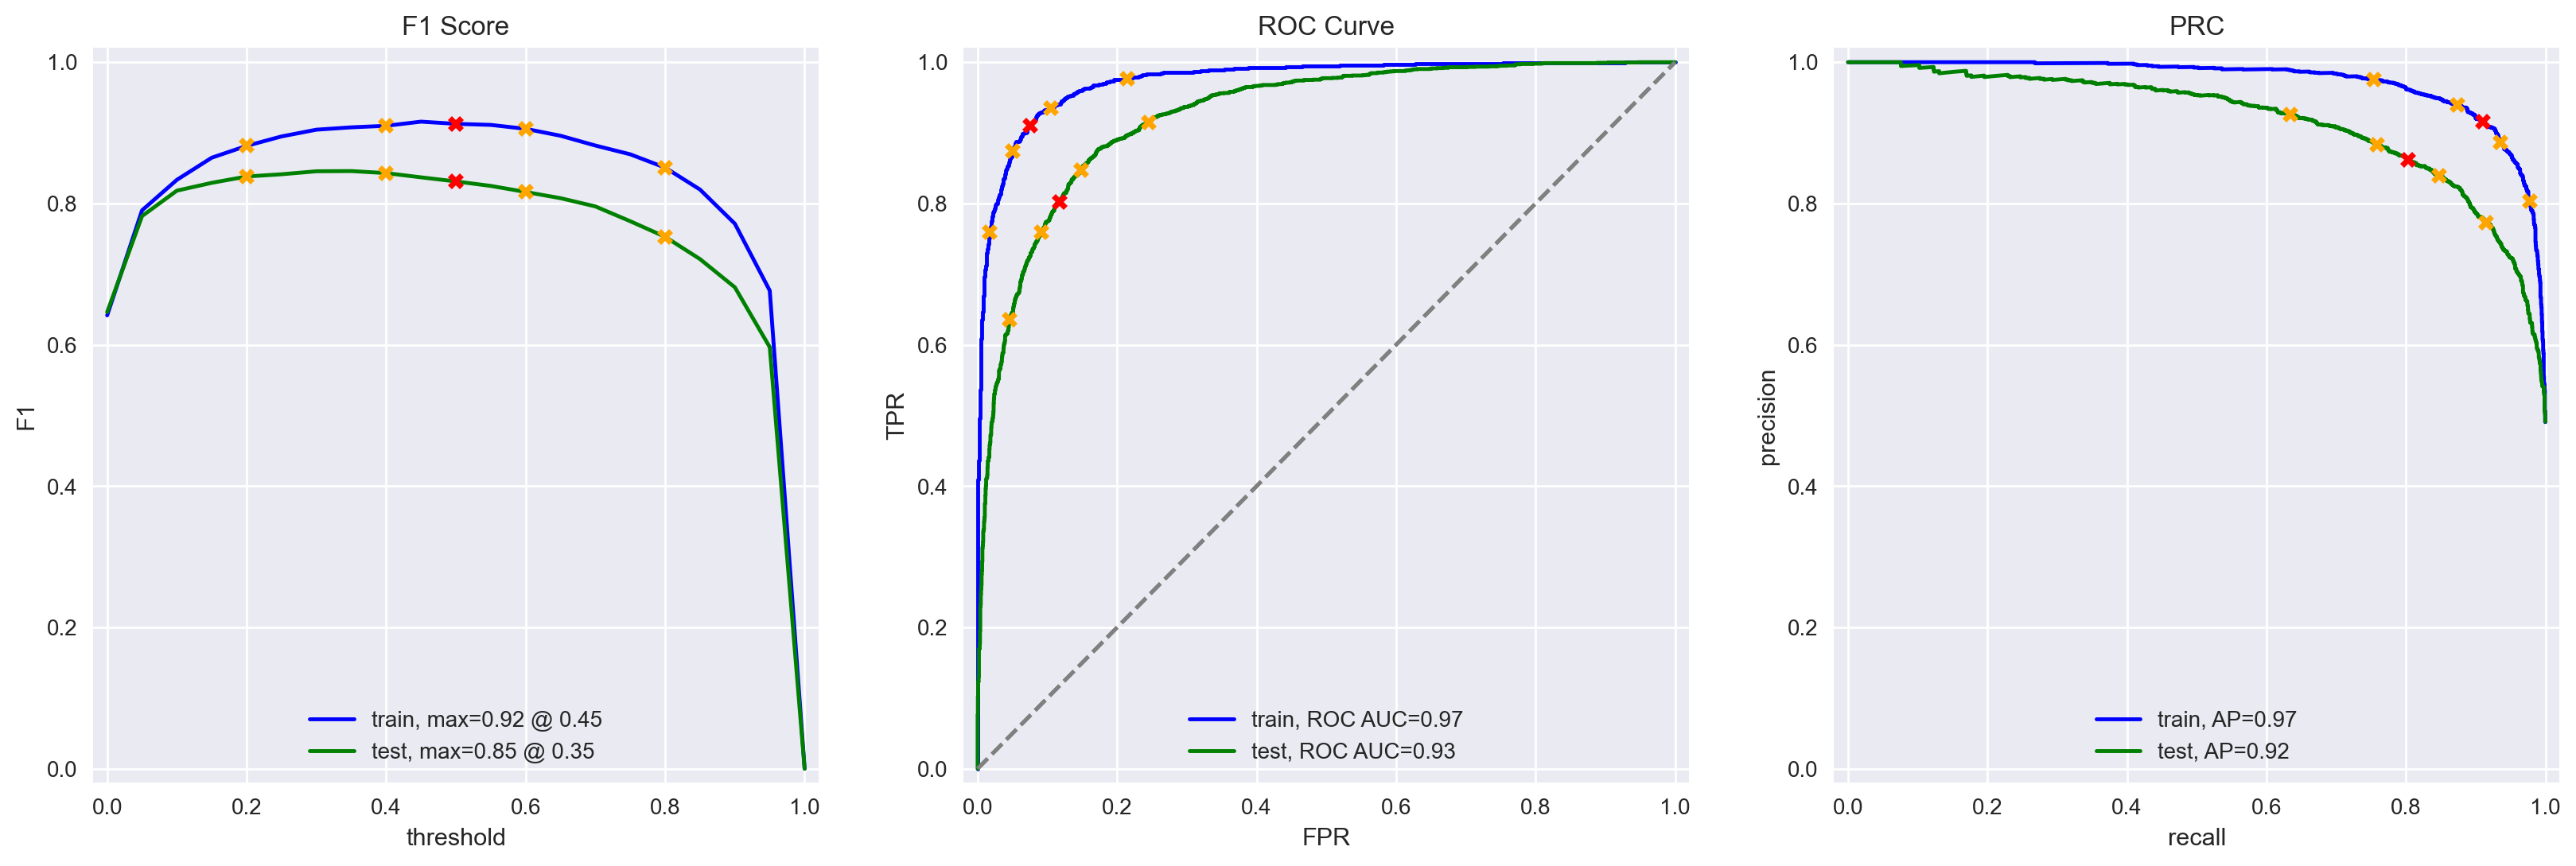

In [53]:
evaluate_model(model_9, train_features_9, train_target.iloc[:5000], test_features_9, test_target.iloc[:5000])

In [66]:
f1_scores.loc[len(f1_scores)]=['B.E.R.T.',0.91,0.83]

## My Reviews

In [55]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'The acting was bad, the script was terrible and the music uninspired but I found myself enjoying the movie and I want to see it again.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)
texts = my_reviews['review_norm']

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...
8,"The acting was bad, the script was terrible an...",the acting was bad the script was terrible and...


### Model 1

In [56]:
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]
my_reviews['model_1']=my_reviews_pred_prob
for i, review in enumerate(texts.str.slice(0, 140)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new dram
0.01:  the acting was bad the script was terrible and the music uninspired but i found myself enjoying the movie and i want to see it again


### Model 3

In [57]:
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews['model_3']=my_reviews_pred_prob
for i, review in enumerate(texts.str.slice(0, 140)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.12:  i did not simply like it not my kind of movie
0.10:  well i was bored and felt asleep in the middle of the movie
0.56:  i was really fascinated with the movie
0.22:  even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new dram
0.01:  the acting was bad the script was terrible and the music uninspired but i found myself enjoying the movie and i want to see it again


### Model 4

In [58]:
tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews['model_4']=my_reviews_pred_prob
for i, review in enumerate(texts.str.slice(0, 140)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.59:  i did not simply like it not my kind of movie
0.47:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.59:  even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0.63:  i didn't expect the reboot to be so good writers really cared about the source material
0.58:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
0.61:  launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new dram
0.07:  the acting was bad the script was terrible and the music uninspired but i found myself enjoying the movie and i want to see it again


### Model 9

In [59]:
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]
my_reviews['model_9']=my_reviews_pred_prob

for i, review in enumerate(texts.str.slice(0, 140)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Using the cpu device.
0.18:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0.26:  i didn't expect the reboot to be so good writers really cared about the source material
0.98:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
0.97:  launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new dram
0.94:  the acting was bad the script was terrible and the music uninspired but i found myself enjoying the movie and i want to see it again


## Visualizing most impatctful words in Negative Reviews compared to Positive Reviews
We are going to use the Word Cloud library to see the most often used words in negative and positive reviews.

In [60]:
positive_reviews=df_reviews_train[df_reviews_train['pos']==1]['review_norm']
negative_reviews=df_reviews_train[df_reviews_train['pos']==0]['review_norm']

In [61]:
#We use the function we created earlier for the top words in respectively negative and positive reviews
positive,temp=top_most_common_words(positive_reviews,200)
negative,temp=top_most_common_words(negative_reviews,200)
#We ignore the top words that are common to both list(like movie, film, review etc)
slim_positive = " ".join(word for word in positive if not word in negative.head(40).values)
slim_negative = " ".join(word for word in negative if not word in positive.head(40).values)

In [62]:
wordcloud_neg = WordCloud().generate(slim_negative)
wordcloud_pos = WordCloud().generate(slim_positive)

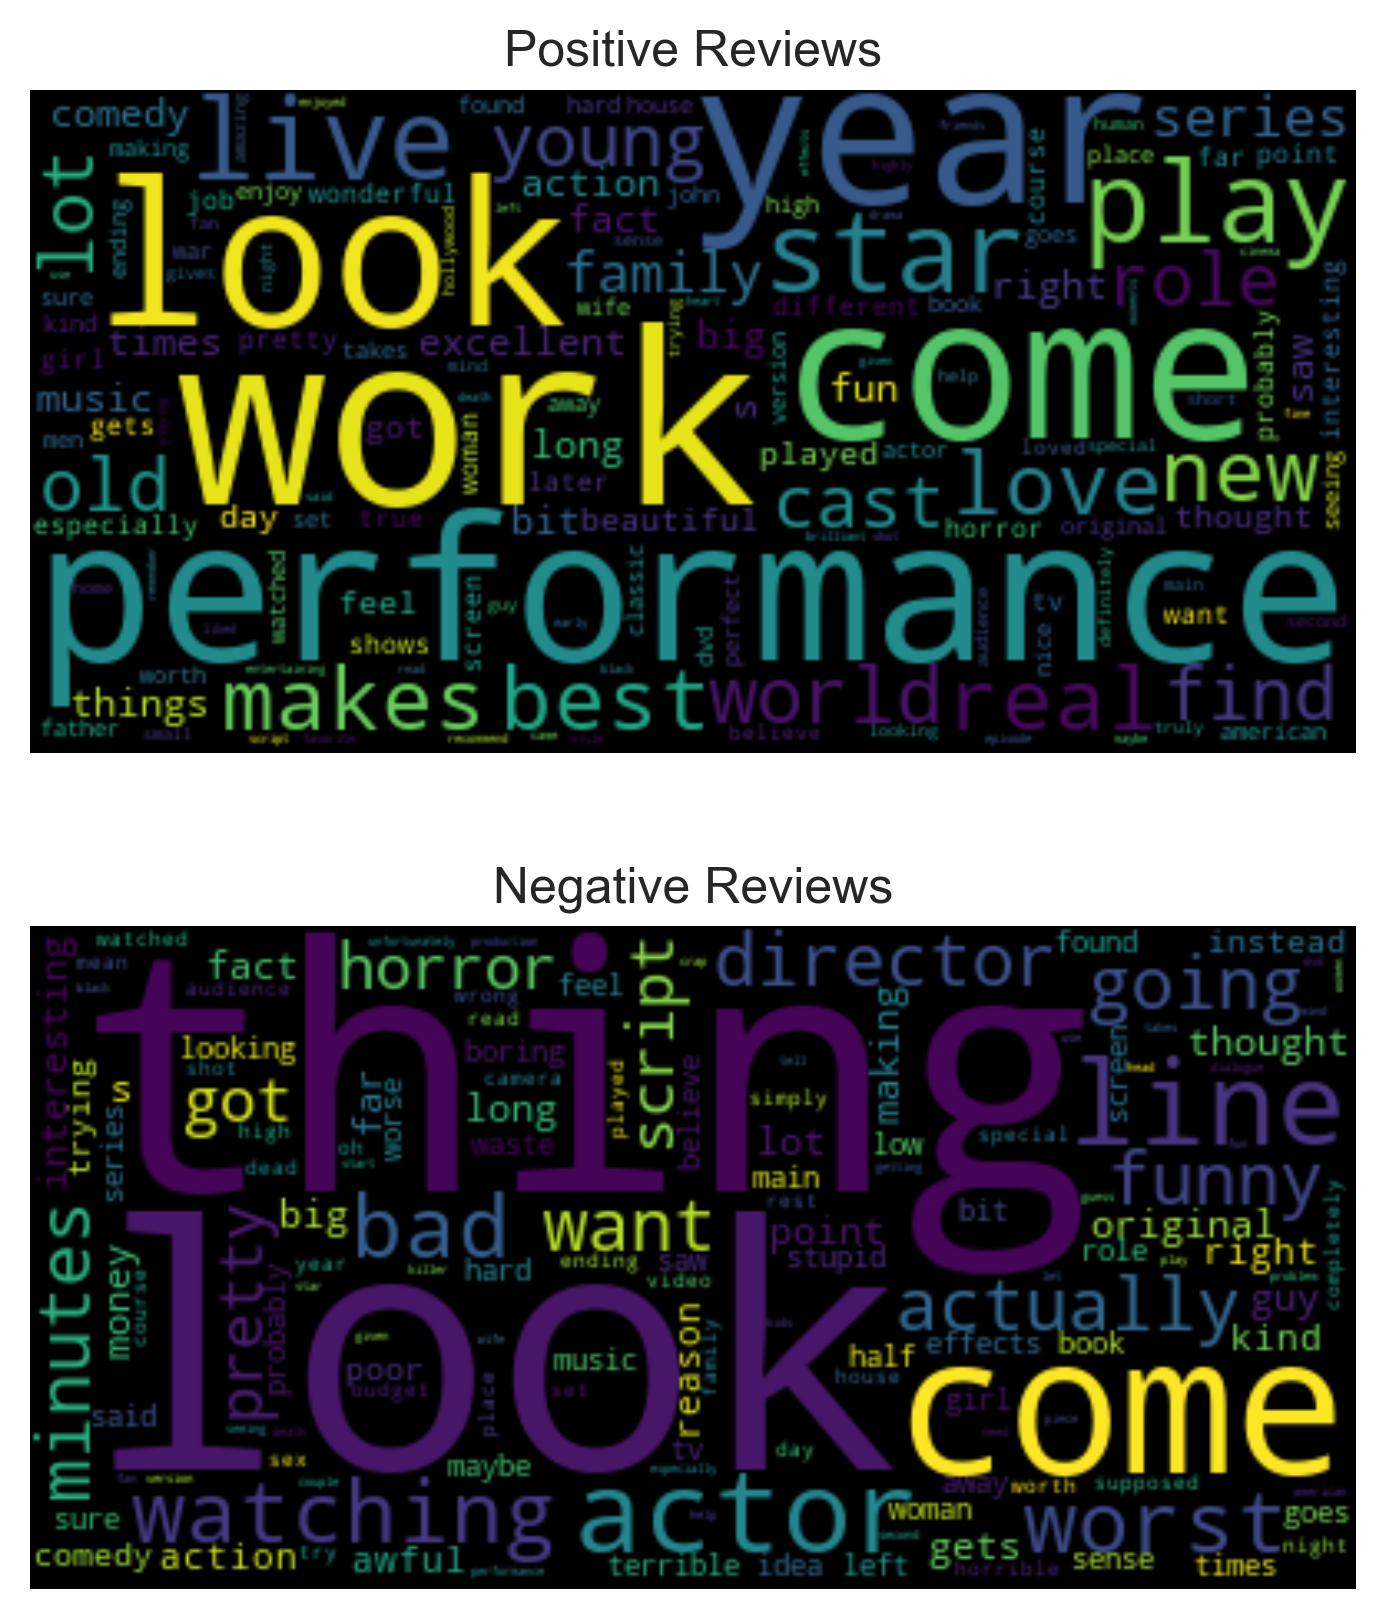

In [63]:
fig, (ax2,ax1) = plt.subplots(2)
fig.set_dpi(150)
plt.title('Visualising the words with the most impact')
ax1.imshow(wordcloud_neg, interpolation='bilinear')
ax1.axis('off')
ax1.set_title("Negative Reviews")
ax2.imshow(wordcloud_pos, interpolation='bilinear')
ax2.set_title("Positive Reviews")
fig.tight_layout()
ax2.axis("off")
plt.show()


## Independent Reviews

In [64]:
my_reviews

,review,review_norm,model_1,model_3,model_4,model_9
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,0.137346,0.122491,0.594093,0.177956
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,0.158324,0.099118,0.473283,0.005563
2,I was really fascinated with the movie,i was really fascinated with the movie,0.535050,0.561915,0.594093,0.992244
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,0.111510,0.221452,0.594093,0.000967
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,0.305875,0.301791,0.631139,0.262157
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,0.470459,0.466534,0.581340,0.981315
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,0.036507,0.022399,0.310009,0.015677
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,0.822823,0.870909,0.614399,0.973387
8,"The acting was bad, the script was terrible an...",the acting was bad the script was terrible and...,0.010403,0.011224,0.065058,0.944348


Here the BERT gives much better results than the other models.
I added the following review designed to fool computerized models: *'The acting was bad, the script was terrible and the music uninspired but I found myself enjoying the movie and I want to see it again.'* While most of the words are negative, the overall sentiment of the review is positive. While the first three models gave it very low score, alone BERT gave it an extremely high score. It shows it really understood the positive context of the review despite the negative wording used. We see this (maybe not as pronounced) on several other reviews that are written in a conflicting manner, where BERT succeeds in understanding the overall sentiment of the piece.

## Overall Conclusion
We have opened and explored the table. We visualized the data in several ways. We saw *Number of Movies and reviews over years*. the *number of reviews per movie*, the *distribution of ratings*, the *difference between positive and negative reviews over the years*. We used the World Cloud library to visualize the most  requently used words in the train and test sets and the most widely used words in Positive and negative reviews.
We normalized the data and split it into train and test sets.
We used 4 machine learning model and a dummy classifier for the baseline. The results are as follows:

In [71]:
properties = {"border": "1px solid black", "width": "65px", "text-align": "center"}
f1_scores.style.hide(axis="index").format(precision=2).set_properties(**properties)

Model Name,Max F1 Train Score,Max F1 Test Score
Dummy Constant Classifier,0.67,0.67
"NLTK, TF-IDF and Logistic Regression",0.94,0.88
"spaCy, TF-IDF and Logistic Regression",0.94,0.88
"spaCy, TF-IDF and LGBMClassifier",0.90,0.85
B.E.R.T.,0.91,0.83


Surprisingly, with an F1 score of 0.88 in the test dataset, simple Logistic Regression gave a better score than both Gradient Boosting and BERT.
But when checking on individual reviews that were not trivial, BERT was the only model to correctly identify the sentiment of the review. It could be that with more training it can give a better score than the others as well.